In [3]:
!pip install pyaurn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
from google.colab import drive
from shutil import make_archive, move
from math import sin, cos

In [5]:
metadata = pyaurn.importMeta().set_index("site_id")

In [6]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "agglomeration", "zone", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-06-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-06-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-06-30,South West,NaN,Teignbridge


In [7]:
def get_site_data(name, year_range):
  try:
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    data["day"] = data["date"].dt.day
    data["month"] = data["date"].dt.month
    data["year"] = data["date"].dt.year
    data["hour"] = data["date"].dt.hour
    data["minute"] = data["date"].dt.minute
    data["second"] = data["date"].dt.second
    if "PM2.5" in data.columns:
      data = data[["day", "month", "year", "hour", "minute", "second", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id").drop("site_id", axis=1)
      return data
  except KeyError:
    return

In [8]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_site_data, name, range(2021, 2022)) for name in metadata.index]
  all_data = wait(all_data)


Index(['ABD', 'ABD9', 'ABD7', 'ABD8', 'ARM6', 'AH', 'ACTH', 'BAAR', 'BALM',
       'BARN',
       ...
       'WIG5', 'WIG3', 'TRAN', 'WOLV', 'WTHG', 'WRAY', 'WREX', 'YW', 'YK10',
       'YK11'],
      dtype='object', name='site_id', length=278)


































































/usr/local/lib/python3.8/dist-packages/pyaurn.py:145: UserWarning: Some data files were not able to be downloaded, check resulting DataFrame carefully
  warnings.warn('Some data files were not able to be downloaded, check resulting DataFrame carefully')
/usr/local/lib/python3.8/dist-packages/pyaurn.py:147: UserWarning: Resulting DataFrame is empty
  warnings.warn('Resulting DataFrame is empty')



























































































































































































































































































































































































































































































































































In [9]:
retrieved_data = [item.result() for item in all_data.done]
display(retrieved_data[0])
concatenated_data = pd.concat(retrieved_data, ignore_index=True)
display(concatenated_data)

None

,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
0,1,1,2021,0,0,0,25.000,Urban Traffic,53.819972,-1.576361
1,1,1,2021,1,0,0,26.000,Urban Traffic,53.819972,-1.576361
2,1,1,2021,2,0,0,5.000,Urban Traffic,53.819972,-1.576361
3,1,1,2021,3,0,0,2.000,Urban Traffic,53.819972,-1.576361
4,1,1,2021,4,0,0,0.000,Urban Traffic,53.819972,-1.576361
...,...,...,...,...,...,...,...,...,...,...
656745,31,12,2021,19,0,0,8.703,Urban Background,53.244131,-1.454946
656746,31,12,2021,20,0,0,6.392,Urban Background,53.244131,-1.454946
656747,31,12,2021,21,0,0,5.189,Urban Background,53.244131,-1.454946
656748,31,12,2021,22,0,0,9.363,Urban Background,53.244131,-1.454946


In [10]:
dataset_length = len(concatenated_data)

#train_dataset = concatenated_data[0:int(0.7*dataset_length)]
#val_dataset = concatenated_data[int(0.7*dataset_length):int(0.9*dataset_length)]
#test_dataset = concatenated_data[int(0.9*dataset_length):]

train_dataset = concatenated_data.sample(frac=0.7)
val_dataset = concatenated_data.drop(train_dataset.index).sample(frac=0.66)
test_dataset = concatenated_data.drop(train_dataset.index).drop(val_dataset.index)
display(train_dataset)
display(val_dataset)
display(test_dataset)

,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
381879,21,9,2021,21,0,0,10.300,Urban Traffic,51.632696,-3.947374
319579,17,10,2021,1,0,0,17.288,Urban Traffic,53.231751,-1.456928
181341,24,11,2021,9,0,0,6.769,Urban Background,53.484810,-2.334139
165392,6,6,2021,17,0,0,5.590,Urban Background,53.028210,-2.175133
387244,12,5,2021,0,0,0,7.000,Urban Industrial,56.010319,-3.704399
...,...,...,...,...,...,...,...,...,...,...
470149,23,10,2021,18,0,0,8.000,Urban Traffic,54.885823,-2.964955
21313,5,7,2021,12,0,0,11.000,Urban Background,52.272257,-0.916605
282210,4,6,2021,3,0,0,6.000,Urban Background,54.978250,-1.610528
208945,15,4,2021,22,0,0,7.594,Urban Background,53.748780,-0.341222


,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
409069,27,11,2021,12,0,0,6.368,Urban Background,52.954730,-1.146447
579575,4,9,2021,19,0,0,24.717,Urban Background,50.371670,-4.142361
425795,29,11,2021,19,0,0,22.000,Urban Traffic,50.735454,-1.780888
357981,25,10,2021,18,0,0,4.458,Rural Background,51.149617,-1.438228
380496,17,6,2021,20,0,0,4.300,Urban Traffic,51.632696,-3.947374
...,...,...,...,...,...,...,...,...,...,...
13918,19,8,2021,13,0,0,0.000,Urban Traffic,50.411463,-4.227678
516978,20,1,2021,13,0,0,4.340,Urban Background,51.521050,-0.213492
144764,3,1,2021,2,0,0,5.283,Urban Background,53.549140,-2.638139
193248,9,4,2021,7,0,0,3.900,Urban Traffic,53.404950,-1.455815


,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
23,1,1,2021,23,0,0,2.000,Urban Traffic,53.819972,-1.576361
25,2,1,2021,1,0,0,1.000,Urban Traffic,53.819972,-1.576361
29,2,1,2021,5,0,0,3.000,Urban Traffic,53.819972,-1.576361
34,2,1,2021,10,0,0,6.000,Urban Traffic,53.819972,-1.576361
35,2,1,2021,11,0,0,2.000,Urban Traffic,53.819972,-1.576361
...,...,...,...,...,...,...,...,...,...,...
656730,31,12,2021,4,0,0,2.288,Urban Background,53.244131,-1.454946
656736,31,12,2021,10,0,0,1.840,Urban Background,53.244131,-1.454946
656737,31,12,2021,11,0,0,3.066,Urban Background,53.244131,-1.454946
656740,31,12,2021,14,0,0,6.863,Urban Background,53.244131,-1.454946


In [13]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("PM2.5")
val_labels = val_features.pop("PM2.5")
test_labels = test_features.pop("PM2.5")

train_features.shape

(459725, 9)

In [14]:
def split_data_for_preprocessing(dataset):
  text_cols = ["location_type"]
  number_cols = ["day", "month", "year", "hour", "minute", "second", "latitude", "longitude"]

  return (dataset[number_cols], dataset[text_cols])

In [22]:
train_features_split = split_data_for_preprocessing(train_features)
val_features_split = split_data_for_preprocessing(val_features)
test_features_split = split_data_for_preprocessing(test_features)

print(train_features_split[0].info())
print(train_features_split[1].info())
print(pd.unique(train_features_split[1]["location_type"]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 381879 to 47500
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   day        459725 non-null  int64  
 1   month      459725 non-null  int64  
 2   year       459725 non-null  int64  
 3   hour       459725 non-null  int64  
 4   minute     459725 non-null  int64  
 5   second     459725 non-null  int64  
 6   latitude   459725 non-null  float64
 7   longitude  459725 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 31.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 381879 to 47500
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   location_type  459725 non-null  object
dtypes: object(1)
memory usage: 7.0+ MB
None
['Urban Traffic' 'Urban Background' 'Urban Industrial' 'Rural Background'
 'Suburban Background']


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 string_lookup_3 (StringLookup)  (None, 6)           0           ['input_9[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 8)           17          ['input_10[0][0]']               
 )                                                                                          

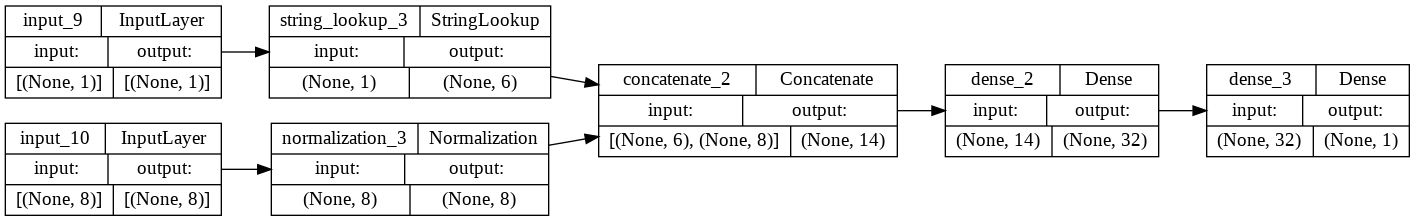

In [26]:
vocabulary = np.array(pd.unique(train_features["location_type"]))
category_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
lookup_layer = tf.keras.layers.StringLookup(vocabulary=vocabulary, output_mode="multi_hot")(category_inputs)

numeric_inputs = tf.keras.layers.Input(shape=(8,))
normalisation_layer = tf.keras.layers.Normalization()
normalisation_layer.adapt(train_features_split[0])
normalisation_layer = normalisation_layer(numeric_inputs)

concatenated_inputs = tf.keras.layers.concatenate([lookup_layer, normalisation_layer])
dense_layer = tf.keras.layers.Dense(32, activation="tanh")(concatenated_inputs)
outputs = tf.keras.layers.Dense(1)(dense_layer)

model = tf.keras.Model(inputs=[category_inputs, numeric_inputs], outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [28]:
print(train_features.dtypes)
history = model.fit(
    (train_features_split[1], train_features_split[0]),
    train_labels,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    ],
    validation_data = ((val_features_split[1], val_features_split[0]), val_labels)
)

day                int64
month              int64
year               int64
hour               int64
minute             int64
second             int64
location_type     object
latitude         float64
longitude        float64
dtype: object
Epoch 1/10
14367/14367 [==============================] - 88s 6ms/step - loss: 40.2861 - mean_absolute_error: 4.3167 - val_loss: 39.6529 - val_mean_absolute_error: 4.2754 - lr: 0.1000
Epoch 2/10
14367/14367 [==============================] - 84s 6ms/step - loss: 38.2953 - mean_absolute_error: 4.2201 - val_loss: 37.4206 - val_mean_absolute_error: 4.1035 - lr: 0.1000
Epoch 3/10
14367/14367 [==============================] - 85s 6ms/step - loss: 37.6234 - mean_absolute_error: 4.1774 - val_loss: 37.8855 - val_mean_absolute_error: 4.0314 - lr: 0.1000
Epoch 4/10
14367/14367 [==============================] - 92s 6ms/step - loss: 34.8050 - mean_absolute_error: 3.9875 - val_loss: 35.3439 - val_mean_absolute_error: 3.9596 - lr: 0.0200
Epoch 5/10
14367/14367 [=

{'loss': [40.286075592041016,
  38.29529571533203,
  37.623435974121094,
  34.80500030517578,
  34.433143615722656,
  33.87309646606445,
  33.82151412963867,
  33.78960418701172,
  33.77465057373047,
  33.677242279052734],
 'mean_absolute_error': [4.316681861877441,
  4.220097541809082,
  4.177351474761963,
  3.987501859664917,
  3.9610369205474854,
  3.9162471294403076,
  3.9149558544158936,
  3.9130048751831055,
  3.9135336875915527,
  3.90659499168396],
 'val_loss': [39.65285873413086,
  37.42063903808594,
  37.885498046875,
  35.343902587890625,
  35.67314147949219,
  34.804229736328125,
  34.76469039916992,
  34.748069763183594,
  34.80258560180664,
  34.693946838378906],
 'val_mean_absolute_error': [4.275351524353027,
  4.103482246398926,
  4.031398296356201,
  3.9595651626586914,
  3.8819477558135986,
  3.8782503604888916,
  3.9503345489501953,
  3.88911771774292,
  3.884363889694214,
  3.8702685832977295],
 'lr': [0.1,
  0.1,
  0.1,
  0.02,
  0.02,
  0.0039999997,
  0.003999999

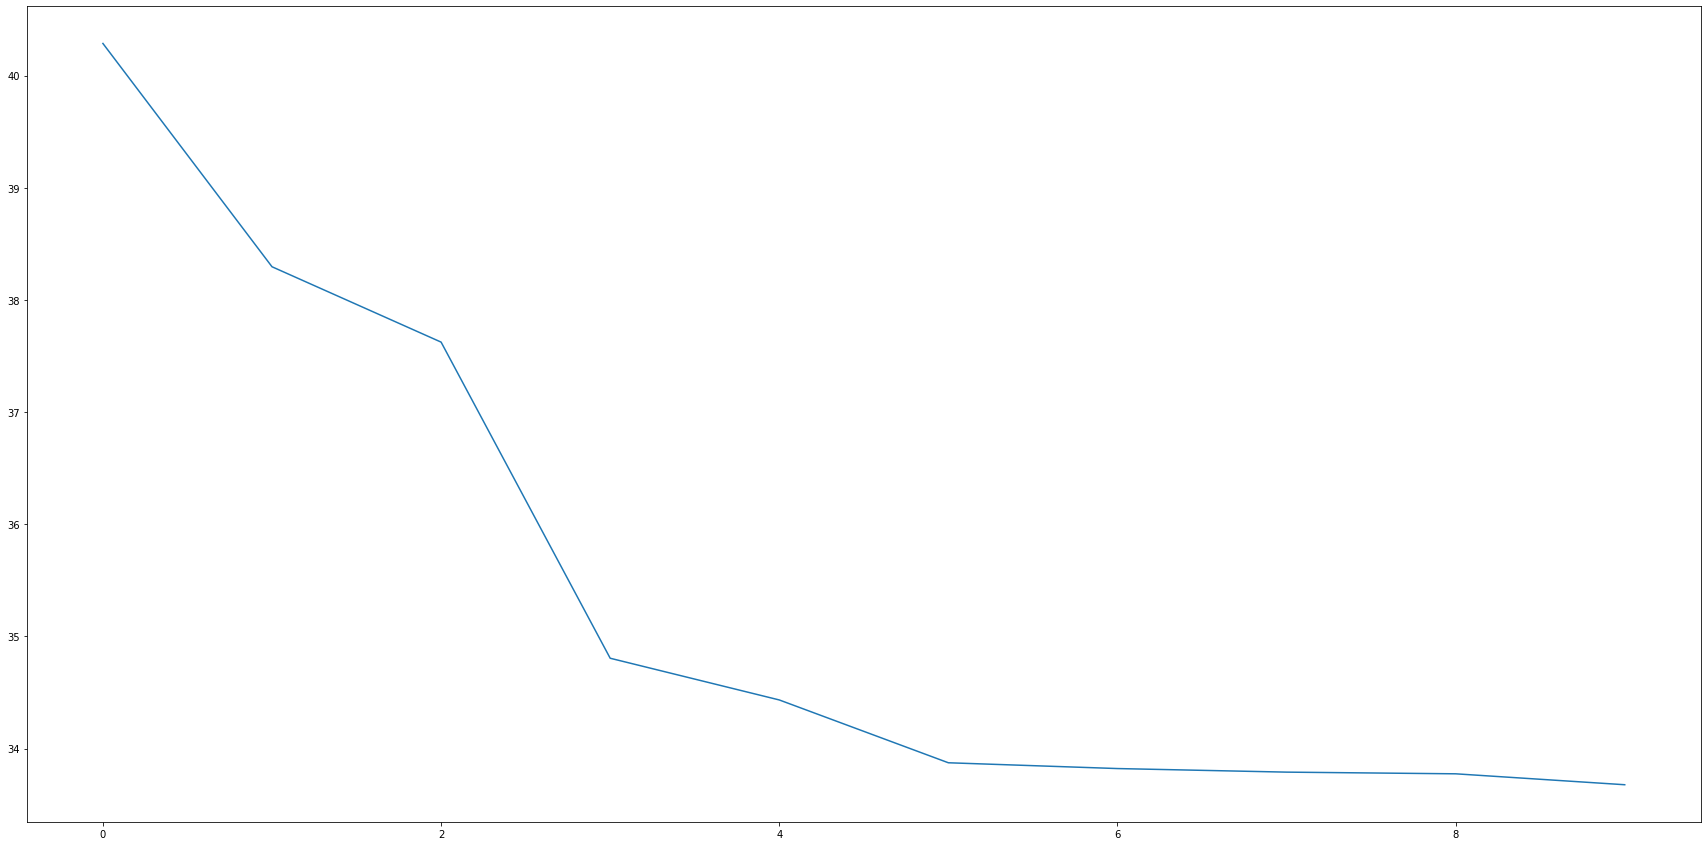

In [29]:
display(history.history)
plt.plot(history.history["loss"])
plt.show()

2094/2094 [==============================] - 4s 2ms/step


array([9.542355 , 7.289645 , 7.2819967, ..., 6.964266 , 6.9642305,
       7.7712507], dtype=float32)

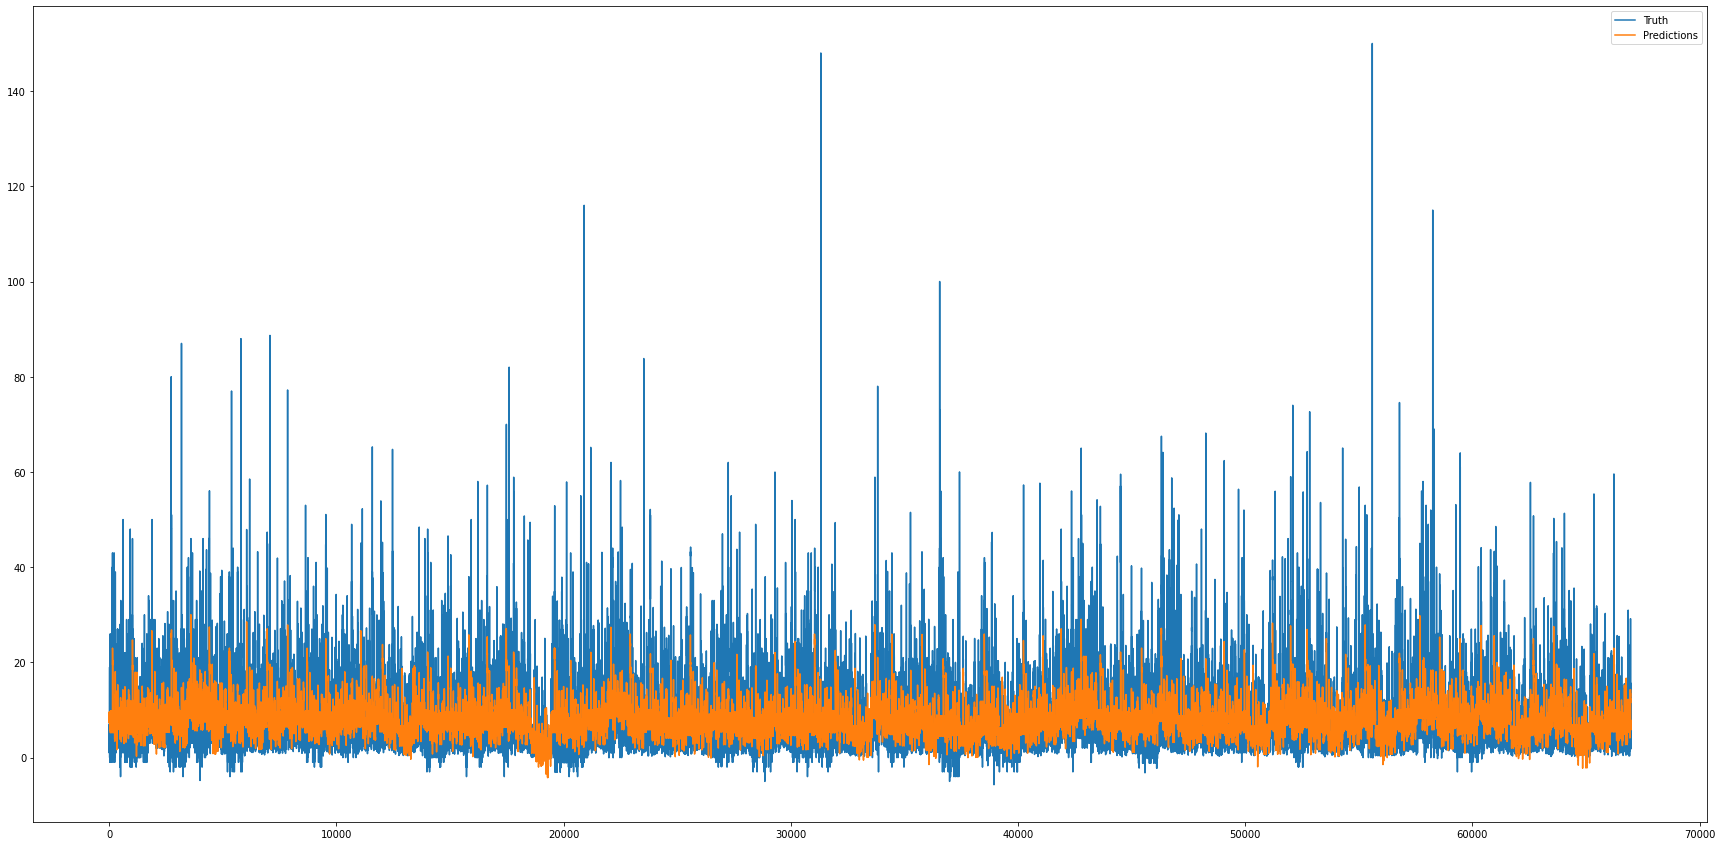

In [30]:
predictions = model.predict([test_features_split[1], test_features_split[0]]).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [ ]:
#drive.mount("/content/gdrive", force_remount=True)
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()